<a href="https://colab.research.google.com/github/ikonushok/My_studying_Data-Science-and-Neyro-Nets-on-Python/blob/master/%D0%98%D1%81%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BA%D1%83%D1%80%D1%81%D0%B0_PLZL_1h.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ultra PRO задание
-------
Найдите любую базу с временными рядами и напишите прогнозирование этого ряда на 10 шагов:
1. Спарсите, разделите и нормализуйте данные
2. Разделите данные на обучающую и проверочную выборки
3. Напишите сеть для прогнозирования временного ряда
4. Сделайте визуализацию результата
5. Напишите ваши результаты и выводы

In [1]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import  Flatten, GRU, LSTM, Bidirectional, UpSampling1D, ZeroPadding1D
from tensorflow.keras.layers import  Conv1D, LocallyConnected1D, SeparableConv1D, Cropping1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, Adamax
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LambdaCallback
from tensorflow.keras import utils
from keras.utils import plot_model

from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir('/content/drive/My Drive/Занятие_7_Временные ряды/data')

## Подготовка данных

### Парсинг данных, построение графика

In [ ]:
#!pip install --upgrade mplfinance
import mplfinance as mpf  
# https://pypi.org/project/mplfinance/
# https://github.com/matplotlib/mplfinance/blob/master/examples/using_lines.ipynb
# https://github.com/matplotlib/mplfinance/blob/master/examples/external_axes.ipynb
# https://github.com/matplotlib/mplfinance/blob/master/examples/addplot.ipynb 

In [ ]:
#!pip install yfinance
import yfinance as yf ## Библиотека для получения данных об акциях
# fetch data by interval (including intraday if period < 60 days)
# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
# (optional, default is '1d')

In [ ]:
## Загрузка и сохранение первичных данных
tickers = ['PLZL.ME']
stock = yf.download(tickers,start='2018-10-01', interval = '1h')
del stock['Adj Close']
stock.to_csv('PLZL_h1_from_yf.csv')
stock

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2018-10-01,4128.0,4128.0,4080.0,4090.0,0
2018-10-01,4090.0,4092.0,4080.0,4090.0,2208
2018-10-01,4090.0,4093.0,4082.0,4088.0,2182
2018-10-01,4087.0,4089.0,4081.0,4089.0,1133
2018-10-01,4090.0,4096.0,4085.0,4090.0,2331
...,...,...,...,...,...
2020-09-16,17188.0,17342.0,17128.5,17334.5,71792
2020-09-16,17334.5,17335.0,17111.0,17136.0,57660
2020-09-16,17145.0,17340.0,17139.0,17325.0,68264


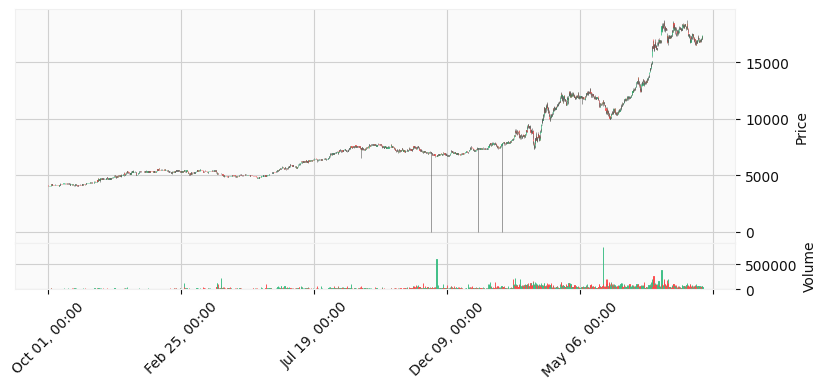

In [ ]:
# график
mpf.plot(stock, figsize=(10, 4), main_panel=0, volume_panel=1, panel_ratios = (5,1),
         type = 'candle', volume = True, style = 'yahoo')

### Загрузка и первичная обработка данных

In [4]:
# загружаем часовые интервалы
df = pd.read_csv('PLZL_h1_from_yf.csv', sep=",")
del df['Date']  # убрали дату, тк она не нужна в обучении (хотя, потом можно добавить число и номер дня недели)
#df = df[:300]  # Убрал старые года, когда была другая плавающая корреляция
df.fillna(method='ffill', inplace=True) # Убираем NaN
print(df.shape)
df[:3]

(4921, 5)


,Open,High,Low,Close,Volume
0,4128.0,4128.0,4080.0,4090.0,0
1,4090.0,4092.0,4080.0,4090.0,2208
2,4090.0,4093.0,4082.0,4088.0,2182


In [5]:
dailyChange = df.pct_change() # Рассчитал дневную доходность
dailyChange.fillna(0, inplace=True) # Заменил NA значения на 0
dailyChange = dailyChange.replace(np.inf, 0)  # Заменил inf (деление на 0) - на 0
print(dailyChange.shape)
#dailyChange.describe()
dailyChange[:3]

(4921, 5)


,Open,High,Low,Close,Volume
0,0.000000,0.000000,0.00000,0.000000,0.000000
1,-0.009205,-0.008721,0.00000,0.000000,0.000000
2,0.000000,0.000244,0.00049,-0.000489,-0.011775


Кумулятивная дневная прибыль полезна для определения стоимости инвестиций через определенные промежуток времени

---
Что было бы, если вложить 1USD  в акцию а начале периода?

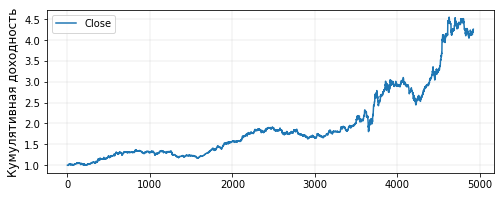

In [6]:
# График Кумулятивной доходности последние 300 баров
((df['Close'].pct_change()+1).cumprod()).plot(figsize=(8, 3))

plt.legend()
plt.ylabel('Кумулятивная доходность', fontsize=12)
plt.grid(linewidth=0.2)
plt.show()

### Подготовка данных

In [7]:
# Оставляю только Close, те не анализирую от набора других данных
#df = df['Close']
#dailyChange = dailyChange['Close']
#dailyChange.shape

In [8]:
#### Функция разделения массива на выборки для обучения нейросети
# sequence = строка массива df
# n_steps = число баров в прошлом для анализа
# future = предсказание какого бара в будущем делаем 

def split_sequence(sequence, n_steps, future):
  # sequence = df.values - это массив из данных
  # n_steps = число баров в прошлом для анализа
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps # находим конечный индекс строки
    if end_ix + (future-1) > len(sequence)-1: # cпроверем чтобы не выйти за пределы массива
      break 
    # получаем X и y
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix + (future-1)]
    X.append(seq_x)
    y.append(seq_y[3]) # тк предсказываем только Close
  return array(X), array(y)

In [9]:
n_steps = 60    # Число баров в прошлом для анализа
future = 10  # Предсказание какого бара в будущем делаем

# Формируем выборки для обучения нейросети
#X, y = split_sequence(dailyChange.values, xLen)  # в изменнениях цен
#X, y = split_sequence(df.values, n_steps)             # цены в рублях
X, y = split_sequence(dailyChange.values, n_steps, future)    # предсказываем изменение цены

print('Массив данных:\t', dailyChange.shape)
print('Массивы X и y:\t', X.shape, y.shape, '\n') # show each sample

# Можно посмотреть, какой бар берется в y
#print(X[0], y[0]) 
#print(X[1], y[1])

Массив данных:	 (4921, 5)
Массивы X и y:	 (4852, 60, 5) (4852,) 



In [10]:
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.005, shuffle=False)
print('xTest: ', xTest.shape, '\tyTest: ', yTest.shape)
print( 'xTrain: ', xTrain.shape, '\tyTrain: ', yTrain.shape)

xTest:  (25, 60, 5) 	yTest:  (25,)
xTrain:  (4827, 60, 5) 	yTrain:  (4827,)


In [11]:
"""### НЕ РАЗОБРАЛСЯ КАК ПРМЕНИТЬ ((

from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Для подготовки yTrain на 10 шагов вперед необходимо создать дополнительный датасет
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

-----------

# делаем обратное преобразование из Scaler
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal //yPred
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования) //yTest
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  yPred = yScaler.inverse_transform(currModel.predict(xTest))
  yTest = yScaler.inverse_transform(yTest)
  return (yPred, yTest)
----

не понимаю, как встроить в модель  на вход и выходе.
гурается на размерности - тогда можно скалитьвать прямо dailyChange???
а тогда каки когда обратно при:
#Прогнозируем данные текущей сетью
currModel = model
(predVal2, yValUnscaled2) = getPred(currModel, xTest, yTest, yScaler)
delta = predVal2 - yValUnscaled2

??? """

'### НЕ РАЗОБРАЛСЯ КАК ПРМЕНИТЬ ((\n\nfrom sklearn.preprocessing import StandardScaler, MinMaxScaler\n\n#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке\nxScaler = MinMaxScaler()\nxScaler.fit(xTrain)\nxTrain = xScaler.transform(xTrain)\nxTest = xScaler.transform(xTest)\n\n#Для подготовки yTrain на 10 шагов вперед необходимо создать дополнительный датасет\nyScaler = MinMaxScaler()\nyScaler.fit(yTrain)\nyTrain = yScaler.transform(yTrain)\nyTest = yScaler.transform(yTest)\n\n-----------\n\n# делаем обратное преобразование из Scaler\n# В аргументы принимает сеть (currModel) и проверочную выборку\n# Выдаёт результаты предсказания predVal //yPred\n# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования) //yTest\ndef getPred(currModel, xVal, yVal, yScaler):\n  # Предсказываем ответ сети по проверочной выборке\n  # И возвращаем исходны масштаб данных, до нормализации\n  yPred = yScaler.inverse_transform(currModel.predict(xTest))\n

In [17]:
### Коллбэк по минимизации отклонения предсказания цены в рублях
def on_epoch_end(epoch, logs):
  yPred = model.predict([xTest])

  absDelta = float(abs(sum(yPred)-sum(yTest)/len(yTest))) #Берём модуль отклоненияsum(absDelta)/len(absDelta)

  yTestCum = (yTest+1).cumprod()
  yPredCum = (yPred+1).cumprod()
  delta = yTestCum[len(yPred)-1] - yPredCum[len(yPred)-1]
  print('Эпоха:', epoch,
        #'  Corr:', np.correlate((yTest+1).cumprod(), (yPred+1).cumprod()), ## для динамики не подхходит
        'Разница  std:', round((np.std(yTest) - np.std(yPred)*100),3),  # присмотреться к этому показателю!
        '  Сред.модуль ошибки:', round(absDelta, 3),
        '  Накопл.откл.: ', round(abs(delta), 3),
        '  ', round((abs(abs(delta) + absDelta))/2, 3), 
        ) #Выводим сообщения

# Коллбэки
pltMae = LambdaCallback(on_epoch_end=on_epoch_end)

## Прогнозирование простыми Нейросетями
---
хороший способ построения тренда ))

### RNN

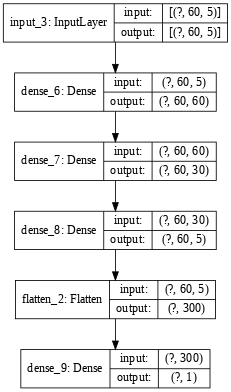

In [ ]:
input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке

x = Dense(xTrain.shape[1], activation='linear', input_dim=xTrain.shape[1])(input)
#x = BatchNormalization()(x)
x = Dense(xTrain.shape[1]//2, activation='linear')(x)
x = Dense(xTrain.shape[2], activation='linear')(x)
x = Flatten()(x)
x = Dense(1, activation='linear')(x)
model = Model(input, x)

plot_model(model, dpi=60, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse')

# коллбэки
early_stopping = EarlyStopping(monitor = 'loss', patience = 8, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9, patience=3, min_lr=1e-06, verbose = 1)

# fit model
history = model.fit(xTrain, yTrain, epochs=20, verbose=1,
                    validation_data=([xTest, yTest]),
                    #callbacks = [early_stopping, reduce_lr])
                    callbacks = [early_stopping, reduce_lr, pltMae])

Epoch 1/20
151/151 [==============================] - ETA: 0s - loss: 0.0029
Эпоха: 0   Corr: [24.57509917]   Сред.модуль ошибки: 0.022   Накопл.откл.:  0.056   Сред.откл.: 0.022    0.039
151/151 [==============================] - 1s 4ms/step - loss: 0.0029 - val_loss: 0.0000e+00
Epoch 2/20
144/151 [===========================>..] - ETA: 0s - loss: 7.6061e-04
Эпоха: 1   Corr: [25.21615481]   Сред.модуль ошибки: 0.029   Накопл.откл.:  0.004   Сред.откл.: 0.029    0.017
151/151 [==============================] - 0s 3ms/step - loss: 7.3660e-04 - val_loss: 0.0000e+00
Epoch 3/20
149/151 [============================>.] - ETA: 0s - loss: 3.4358e-04
Эпоха: 2   Corr: [24.741726]   Сред.модуль ошибки: 0.017   Накопл.откл.:  0.047   Сред.откл.: 0.017    0.032
151/151 [==============================] - 0s 3ms/step - loss: 3.4161e-04 - val_loss: 0.0000e+00
Epoch 4/20
150/151 [============================>.] - ETA: 0s - loss: 1.6961e-04
Эпоха: 3   Corr: [23.61415954]   Сред.модуль ошибки: 0.113   Н

1/1 [==============================] - 0s 3ms/step

Средний модуль ошибки 0.016
Корреляция yTest и yPred накопленных:  [25.5279198] 



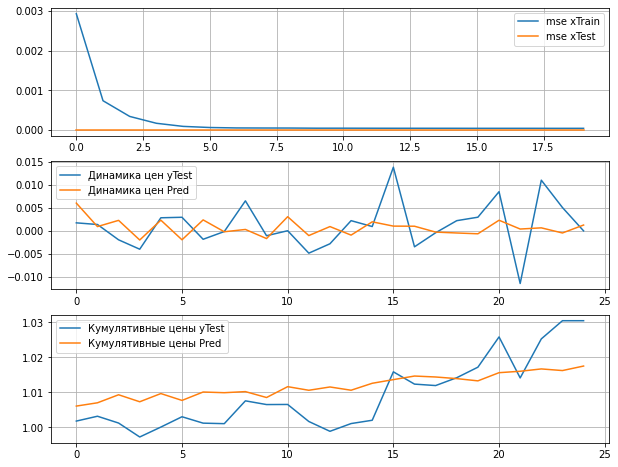

In [ ]:
#### prediction

#yPred = model.predict([xTest], verbose=1)
absDelta = float(abs(sum(yPred)-sum(yTest)/len(yTest))) #Берём модуль отклоненияsum(absDelta)/len(absDelta)
print('\nСредний модуль ошибки', round(absDelta, 3))
print('Корреляция yTest и yPred накопленных: ', np.correlate((yTest+1).cumprod(), (yPred+1).cumprod()), '\n')

#Выводим график ежедневной динамики цен
ax3 = plt.subplot2grid(shape=(3,1), loc=(0,0))
ax3 = plt.plot(history.history['loss'], label='mse xTrain')
ax3 = plt.plot(history.history['val_loss'], label='mse xTest')
plt.legend()
plt.grid()

#Выводим график ежедневной динамики цен
ax2 = plt.subplot2grid(shape=(3,1), loc=(1,0))
ax2 = plt.plot(yTest, label='Динамика цен yTest')
ax2 = plt.plot(yPred, label='Динамика цен Pred')
plt.legend()
plt.grid()

#Выводим график НАКОПЛЕННЫХ изменнений цен
ax1 = plt.subplot2grid(shape=(3,1), loc=(2,0)) # и ax2 - нижняя строка
ax1 = plt.plot((yTest+1).cumprod(), label='Кумулятивные цены yTest')
ax1 = plt.plot((yPred+1).cumprod(), label='Кумулятивные цены Pred')
plt.legend()
plt.grid()

plt.gcf().set_size_inches(10,8)

### Bidirectional LSTM

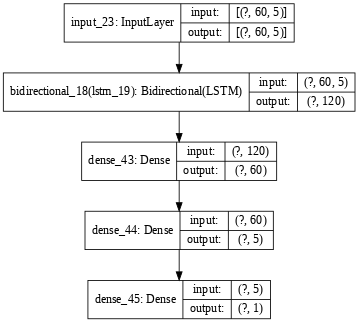

In [ ]:
input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке
x = Bidirectional(LSTM(xTrain.shape[1]))(input)
x = Dense(xTrain.shape[1], activation='linear')(x)
x = Dense(xTrain.shape[2], activation='linear')(x)
x = Dense(1, activation='linear')(x)

model = Model(input, x)

plot_model(model, dpi=60, show_shapes=True, show_layer_names=True)

In [ ]:
#model = load_model('PLZL_Predict_Concatenate.h5')

In [ ]:
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='mse')

# коллбэки
early_stopping = EarlyStopping(monitor = 'loss', patience = 8, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, min_lr=1e-06, verbose = 1)

# fit model
history = model.fit(xTrain, yTrain, epochs=20, verbose=1,
                    validation_data=([xTest, yTest]),
                    #callbacks = [early_stopping, reduce_lr])
                    callbacks = [early_stopping, reduce_lr, pltMae])

Epoch 1/20
146/151 [============================>.] - ETA: 0s - loss: 8.3602e-04
Эпоха: 0   Сред.модуль ошибки: 0.081   Накопл.откл.:  0.108   Сред.откл.: 0.081    0.095
151/151 [==============================] - 2s 15ms/step - loss: 8.1252e-04 - val_loss: 0.0000e+00
Epoch 2/20
148/151 [============================>.] - ETA: 0s - loss: 7.1840e-05
Эпоха: 1   Сред.модуль ошибки: 0.054   Накопл.откл.:  0.082   Сред.откл.: 0.054    0.068
151/151 [==============================] - 1s 9ms/step - loss: 7.1287e-05 - val_loss: 0.0000e+00
Epoch 3/20
148/151 [============================>.] - ETA: 0s - loss: 6.6388e-05
Эпоха: 2   Сред.модуль ошибки: 0.119   Накопл.откл.:  0.096   Сред.откл.: 0.119    0.107
151/151 [==============================] - 1s 8ms/step - loss: 6.5998e-05 - val_loss: 0.0000e+00
Epoch 4/20
147/151 [============================>.] - ETA: 0s - loss: 6.4527e-05
Эпоха: 3   Сред.модуль ошибки: 0.069   Накопл.откл.:  0.096   Сред.откл.: 0.069    0.083
151/151 [===================

1/1 [==============================] - 0s 1ms/step

Средний модуль ошибки 0.017
Корреляция yTest и yPred накопленных:  [25.51618076] 



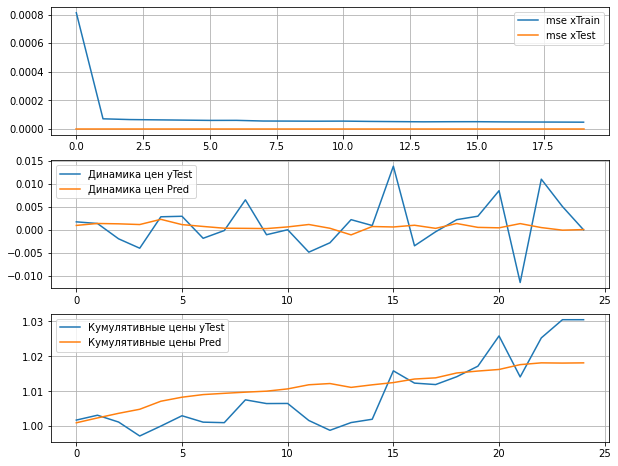

In [ ]:
# prediction
yPred = model.predict([xTest], verbose=1)
absDelta = float(abs(sum(yPred)-sum(yTest)/len(yTest))) #Берём модуль отклоненияsum(absDelta)/len(absDelta)
print('\nСредний модуль ошибки', round(absDelta, 3))
print('Корреляция yTest и yPred накопленных: ', np.correlate((yTest+1).cumprod(), (yPred+1).cumprod()), '\n')

#Выводим график ежедневной динамики цен
ax3 = plt.subplot2grid(shape=(3,1), loc=(0,0))
ax3 = plt.plot(history.history['loss'], label='mse xTrain')
ax3 = plt.plot(history.history['val_loss'], label='mse xTest')
plt.legend()
plt.grid()

#Выводим график ежедневной динамики цен
ax2 = plt.subplot2grid(shape=(3,1), loc=(1,0))
ax2 = plt.plot(yTest, label='Динамика цен yTest')
ax2 = plt.plot(yPred, label='Динамика цен Pred')
plt.legend()
plt.grid()

#Выводим график НАКОПЛЕННЫХ изменнений цен
ax1 = plt.subplot2grid(shape=(3,1), loc=(2,0)) # и ax2 - нижняя строка
ax1 = plt.plot((yTest+1).cumprod(), label='Кумулятивные цены yTest')
ax1 = plt.plot((yPred+1).cumprod(), label='Кумулятивные цены Pred')
plt.legend()
plt.grid()

plt.gcf().set_size_inches(10,8)

In [ ]:
#model.save('PLZL_Concatenate.h5') 

### Сеть LSTM

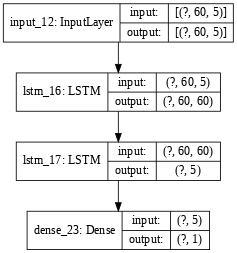

In [42]:
# LSTM
input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке
x = LSTM(xTrain.shape[1], return_sequences="True")(input)
#x = Flatten()(x)
x = LSTM(xTrain.shape[2])(x)
#x = Dense(xTrain.shape[1], activation='linear')(x)
#x = Dense(xTrain.shape[2], activation='linear')(x)
x = Dense(1, activation='linear')(x)

model = Model(input, x)

plot_model(model, dpi=60, show_shapes=True, show_layer_names=True)

In [ ]:
#model.save('PLZL_LSTM.h5') 
#model = load_model('PLZL_LSTM.h5')

In [43]:
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='mse')

# коллбэки
early_stopping = EarlyStopping(monitor = 'loss', patience = 8, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, min_lr=1e-06, verbose = 1)

# fit model
history = model.fit(xTrain, yTrain, epochs=20, verbose=1,
                    validation_data=([xTest, yTest]),
                    #callbacks = [early_stopping, reduce_lr])
                    callbacks = [early_stopping, reduce_lr, pltMae])

Epoch 1/20
146/151 [============================>.] - ETA: 0s - loss: 1.7159e-04
Эпоха: 0   Сред.модуль ошибки: 0.065   Накопл.откл.:  0.092   Сред.откл.: 0.065    0.079
151/151 [==============================] - 2s 17ms/step - loss: 1.6720e-04 - val_loss: 0.0000e+00
Epoch 2/20
150/151 [============================>.] - ETA: 0s - loss: 5.3135e-05
Эпоха: 1   Сред.модуль ошибки: 0.053   Накопл.откл.:  0.025   Сред.откл.: 0.053    0.039
151/151 [==============================] - 1s 9ms/step - loss: 5.3172e-05 - val_loss: 0.0000e+00
Epoch 3/20
148/151 [============================>.] - ETA: 0s - loss: 4.8590e-05
Эпоха: 2   Сред.модуль ошибки: 0.065   Накопл.откл.:  0.038   Сред.откл.: 0.065    0.052
151/151 [==============================] - 1s 9ms/step - loss: 4.8721e-05 - val_loss: 0.0000e+00
Epoch 4/20
151/151 [==============================] - ETA: 0s - loss: 4.6214e-05
Эпоха: 3   Сред.модуль ошибки: 0.058   Накопл.откл.:  0.086   Сред.откл.: 0.058    0.072
151/151 [===================

1/1 [==============================] - 0s 2ms/step

Средний модуль ошибки 0.017
Корреляция yTest и yPred накопленных:  [25.51190589] 



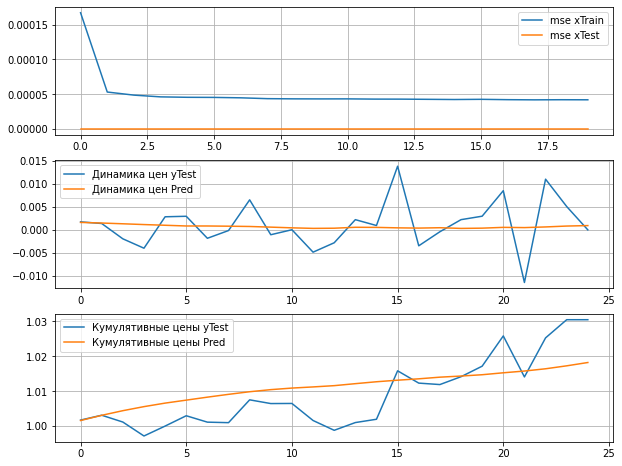

In [44]:
# prediction
yPred = model.predict([xTest], verbose=1)
absDelta = float(abs(sum(yPred)-sum(yTest)/len(yTest))) #Берём модуль отклоненияsum(absDelta)/len(absDelta)
print('\nСредний модуль ошибки', round(absDelta, 3))
print('Корреляция yTest и yPred накопленных: ', np.correlate((yTest+1).cumprod(), (yPred+1).cumprod()), '\n')

#Выводим график ежедневной динамики цен
ax3 = plt.subplot2grid(shape=(3,1), loc=(0,0))
ax3 = plt.plot(history.history['loss'], label='mse xTrain')
ax3 = plt.plot(history.history['val_loss'], label='mse xTest')
plt.legend()
plt.grid()

#Выводим график ежедневной динамики цен
ax2 = plt.subplot2grid(shape=(3,1), loc=(1,0))
ax2 = plt.plot(yTest, label='Динамика цен yTest')
ax2 = plt.plot(yPred, label='Динамика цен Pred')
plt.legend()
plt.grid()

#Выводим график НАКОПЛЕННЫХ изменнений цен
ax1 = plt.subplot2grid(shape=(3,1), loc=(2,0)) # и ax2 - нижняя строка
ax1 = plt.plot((yTest+1).cumprod(), label='Кумулятивные цены yTest')
ax1 = plt.plot((yPred+1).cumprod(), label='Кумулятивные цены Pred')
plt.legend()
plt.grid()

plt.gcf().set_size_inches(10,8)

### Сеть GRU

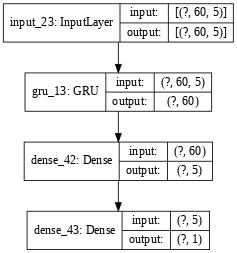

In [ ]:
# GRU
input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке
x = GRU(xTrain.shape[1])(input)
x = Dense(xTrain.shape[1], activation='linear')(x)
#x = Dense(xTrain.shape[2], activation='linear')(x)
x = Dense(1, activation='linear')(x)

model = Model(input, x)

plot_model(model, dpi=60, show_shapes=True, show_layer_names=True)

In [ ]:
#model.save('PLZL_GRU.h5') 
#model = load_model('PLZL_GRU.h5')

In [ ]:
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='mse')

# коллбэки
early_stopping = EarlyStopping(monitor = 'loss', patience = 8, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, min_lr=1e-06, verbose = 1)

# fit model
history = model.fit(xTrain, yTrain, epochs=20, verbose=1,
                    validation_data=([xTest, yTest]),
                    #callbacks = [early_stopping, reduce_lr])
                    callbacks = [early_stopping, reduce_lr, pltMae])

Epoch 1/20
140/151 [==========================>...] - ETA: 0s - loss: 0.0082
Эпоха: 0   Сред.модуль ошибки: 0.008   Накопл.откл.:  0.038   Сред.откл.: 0.008    0.023
151/151 [==============================] - 1s 8ms/step - loss: 0.0076 - val_loss: 0.0000e+00
Epoch 2/20
141/151 [===========================>..] - ETA: 0s - loss: 4.5843e-04
Эпоха: 1   Сред.модуль ошибки: 0.018   Накопл.откл.:  0.012   Сред.откл.: 0.018    0.015
151/151 [==============================] - 1s 5ms/step - loss: 4.4214e-04 - val_loss: 0.0000e+00
Epoch 3/20
142/151 [===========================>..] - ETA: 0s - loss: 1.5039e-04
Эпоха: 2   Сред.модуль ошибки: 0.009   Накопл.откл.:  0.02   Сред.откл.: 0.009    0.015
151/151 [==============================] - 1s 5ms/step - loss: 1.4403e-04 - val_loss: 0.0000e+00
Epoch 4/20
141/151 [===========================>..] - ETA: 0s - loss: 7.0396e-05
Эпоха: 3   Сред.модуль ошибки: 0.027   Накопл.откл.:  0.002   Сред.откл.: 0.027    0.014
151/151 [=============================

1/1 [==============================] - 0s 3ms/step

Средний модуль ошибки 0.054
Корреляция yTest и yPred накопленных:  [24.55424888] 



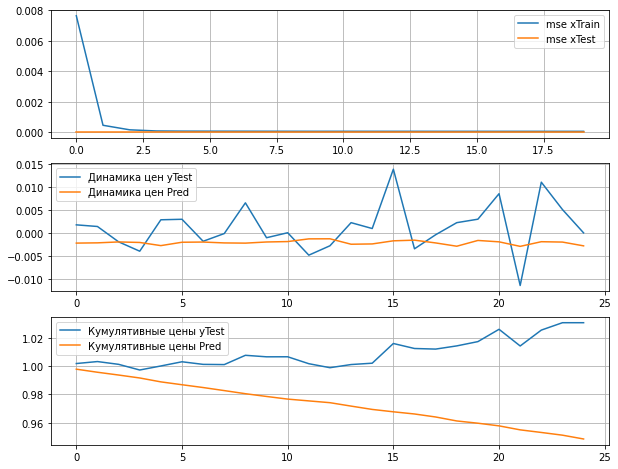

In [ ]:
# prediction
yPred = model.predict([xTest], verbose=1)
absDelta = float(abs(sum(yPred)-sum(yTest)/len(yTest))) #Берём модуль отклоненияsum(absDelta)/len(absDelta)
print('\nСредний модуль ошибки', round(absDelta, 3))
print('Корреляция yTest и yPred накопленных: ', np.correlate((yTest+1).cumprod(), (yPred+1).cumprod()), '\n')

#Выводим график ежедневной динамики цен
ax3 = plt.subplot2grid(shape=(3,1), loc=(0,0))
ax3 = plt.plot(history.history['loss'], label='mse xTrain')
ax3 = plt.plot(history.history['val_loss'], label='mse xTest')
plt.legend()
plt.grid()

#Выводим график ежедневной динамики цен
ax2 = plt.subplot2grid(shape=(3,1), loc=(1,0))
ax2 = plt.plot(yTest, label='Динамика цен yTest')
ax2 = plt.plot(yPred, label='Динамика цен Pred')
plt.legend()
plt.grid()

#Выводим график НАКОПЛЕННЫХ изменнений цен
ax1 = plt.subplot2grid(shape=(3,1), loc=(2,0)) # и ax2 - нижняя строка
ax1 = plt.plot((yTest+1).cumprod(), label='Кумулятивные цены yTest')
ax1 = plt.plot((yPred+1).cumprod(), label='Кумулятивные цены Pred')
plt.legend()
plt.grid()

plt.gcf().set_size_inches(10,8)

### CNN

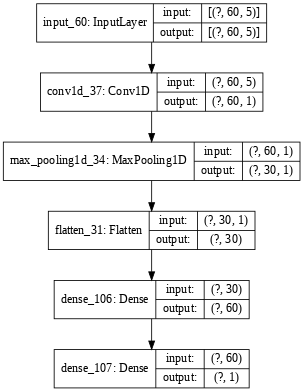

In [ ]:
# Conv1D
input = Input(shape = (xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке
x = Conv1D(1, 2, padding='same', activation='linear')(input) # схлопнул все 5 столбцов в 1
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(xTrain.shape[1], activation='linear')(x)
#x = Dense(xTrain.shape[2], activation='linear')(x)
x = Dense(1, activation='linear')(x)

model = Model(input, x)

plot_model(model, dpi=60, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='mse')

# коллбэки
early_stopping = EarlyStopping(monitor = 'loss', patience = 8, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, min_lr=1e-06, verbose = 1)

# fit model
history = model.fit(xTrain, yTrain, epochs=20, verbose=1,
                    validation_data=([xTest, yTest]),
                    #callbacks = [early_stopping, reduce_lr])
                    callbacks = [early_stopping, reduce_lr, pltMae])

Epoch 1/20
138/151 [==========================>...] - ETA: 0s - loss: 0.0716
Эпоха: 0   Сред.модуль ошибки: 0.371   Накопл.откл.:  0.452   Сред.откл.: 0.371    0.411
151/151 [==============================] - 0s 3ms/step - loss: 0.0680 - val_loss: 0.0000e+00
Epoch 2/20
143/151 [===========================>..] - ETA: 0s - loss: 0.0150
Эпоха: 1   Сред.модуль ошибки: 0.096   Накопл.откл.:  0.167   Сред.откл.: 0.096    0.131
151/151 [==============================] - 0s 2ms/step - loss: 0.0145 - val_loss: 0.0000e+00
Epoch 3/20
137/151 [==========================>...] - ETA: 0s - loss: 0.0031
Эпоха: 2   Сред.модуль ошибки: 0.131   Накопл.откл.:  0.157   Сред.откл.: 0.131    0.144
151/151 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0000e+00
Epoch 4/20
145/151 [===========================>..] - ETA: 0s - loss: 1.7670e-04
Эпоха: 3   Сред.модуль ошибки: 0.038   Накопл.откл.:  0.01   Сред.откл.: 0.038    0.024
151/151 [==============================] - 0s 2ms/step

1/1 [==============================] - 0s 1ms/step

Средний модуль ошибки 0.023
Корреляция yTest и yPred накопленных:  [25.51101895] 



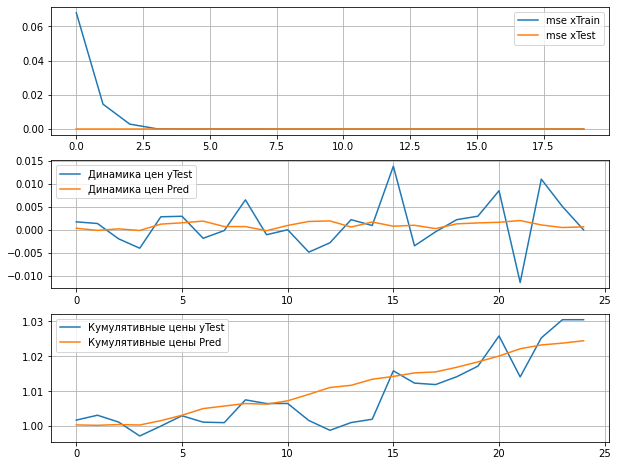

In [ ]:
# prediction
yPred = model.predict([xTest], verbose=1)
absDelta = float(abs(sum(yPred)-sum(yTest)/len(yTest))) #Берём модуль отклоненияsum(absDelta)/len(absDelta)
print('\nСредний модуль ошибки', round(absDelta, 3))
print('Корреляция yTest и yPred накопленных: ', np.correlate((yTest+1).cumprod(), (yPred+1).cumprod()), '\n')

#Выводим график ежедневной динамики цен
ax3 = plt.subplot2grid(shape=(3,1), loc=(0,0))
ax3 = plt.plot(history.history['loss'], label='mse xTrain')
ax3 = plt.plot(history.history['val_loss'], label='mse xTest')
plt.legend()
plt.grid()

#Выводим график ежедневной динамики цен
ax2 = plt.subplot2grid(shape=(3,1), loc=(1,0))
ax2 = plt.plot(yTest, label='Динамика цен yTest')
ax2 = plt.plot(yPred, label='Динамика цен Pred')
plt.legend()
plt.grid()

#Выводим график НАКОПЛЕННЫХ изменнений цен
ax1 = plt.subplot2grid(shape=(3,1), loc=(2,0)) # и ax2 - нижняя строка
ax1 = plt.plot((yTest+1).cumprod(), label='Кумулятивные цены yTest')
ax1 = plt.plot((yPred+1).cumprod(), label='Кумулятивные цены Pred')
plt.legend()
plt.grid()

plt.gcf().set_size_inches(10,8)

### CNN: LocallyConnected1D

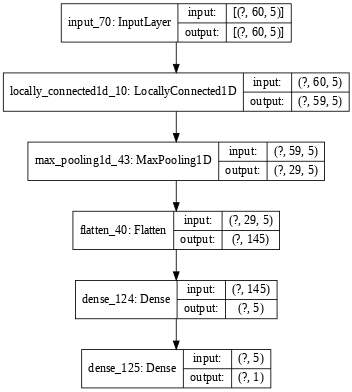

In [ ]:
# CNN: LocallyConnected1D
input = Input(shape = (xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке
x = LocallyConnected1D(5, 2, activation='relu')(input) # слопнул все 5 столбцов в 1
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
#x = Dense(xTrain.shape[1], activation='linear')(x)
x = Dense(xTrain.shape[2], activation='linear')(x)
x = Dense(1, activation='linear')(x)

model = Model(input, x)

plot_model(model, dpi=60, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='mse')

# коллбэки
early_stopping = EarlyStopping(monitor = 'loss', patience = 8, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, min_lr=1e-06, verbose = 1)

# fit model
history = model.fit(xTrain, yTrain, epochs=20, verbose=0,
                    validation_data=([xTest, yTest]),
                    #callbacks = [early_stopping, reduce_lr])
                    callbacks = [early_stopping, reduce_lr, pltMae])


Эпоха: 0   Сред.модуль ошибки: 0.129   Накопл.откл.:  0.162   Сред.откл.: 0.129    0.146

Эпоха: 1   Сред.модуль ошибки: 0.038   Накопл.откл.:  0.008   Сред.откл.: 0.038    0.023

Эпоха: 2   Сред.модуль ошибки: 0.022   Накопл.откл.:  0.009   Сред.откл.: 0.022    0.015

Эпоха: 3   Сред.модуль ошибки: 0.049   Накопл.откл.:  0.078   Сред.откл.: 0.049    0.064

Эпоха: 4   Сред.модуль ошибки: 0.056   Накопл.откл.:  0.027   Сред.откл.: 0.056    0.042

Эпоха: 5   Сред.модуль ошибки: 0.121   Накопл.откл.:  0.099   Сред.откл.: 0.121    0.11

Эпоха: 6   Сред.модуль ошибки: 0.046   Накопл.откл.:  0.017   Сред.откл.: 0.046    0.031

Эпоха: 7   Сред.модуль ошибки: 0.025   Накопл.откл.:  0.004   Сред.откл.: 0.025    0.015

Эпоха: 8   Сред.модуль ошибки: 0.031   Накопл.откл.:  0.002   Сред.откл.: 0.031    0.017

Эпоха: 9   Сред.модуль ошибки: 0.076   Накопл.откл.:  0.049   Сред.откл.: 0.076    0.063

Epoch 00011: ReduceLROnPlateau reducing learning rate to 8.999999772640876e-05.

Эпоха: 10   Сред.мо

1/1 [==============================] - 0s 2ms/step

Средний модуль ошибки 0.02
Корреляция yTest и yPred накопленных:  [25.35423949] 



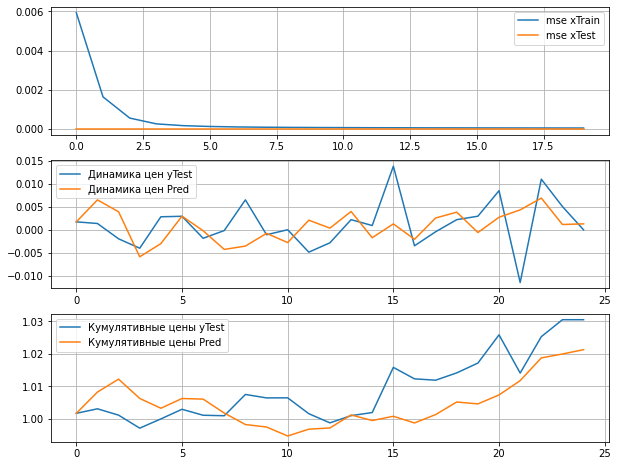

In [ ]:
# prediction
yPred = model.predict([xTest], verbose=1)
absDelta = float(abs(sum(yPred)-sum(yTest)/len(yTest))) #Берём модуль отклоненияsum(absDelta)/len(absDelta)
print('\nСредний модуль ошибки', round(absDelta, 3))
print('Корреляция yTest и yPred накопленных: ', np.correlate((yTest+1).cumprod(), (yPred+1).cumprod()), '\n')

#Выводим график ежедневной динамики цен
ax3 = plt.subplot2grid(shape=(3,1), loc=(0,0))
ax3 = plt.plot(history.history['loss'], label='mse xTrain')
ax3 = plt.plot(history.history['val_loss'], label='mse xTest')
plt.legend()
plt.grid()

#Выводим график ежедневной динамики цен
ax2 = plt.subplot2grid(shape=(3,1), loc=(1,0))
ax2 = plt.plot(yTest, label='Динамика цен yTest')
ax2 = plt.plot(yPred, label='Динамика цен Pred')
plt.legend()
plt.grid()

#Выводим график НАКОПЛЕННЫХ изменнений цен
ax1 = plt.subplot2grid(shape=(3,1), loc=(2,0)) # и ax2 - нижняя строка
ax1 = plt.plot((yTest+1).cumprod(), label='Кумулятивные цены yTest')
ax1 = plt.plot((yPred+1).cumprod(), label='Кумулятивные цены Pred')
plt.legend()
plt.grid()

plt.gcf().set_size_inches(10,8)

### CNN: с извращениями
----
лучшее - враг хорошего.. 

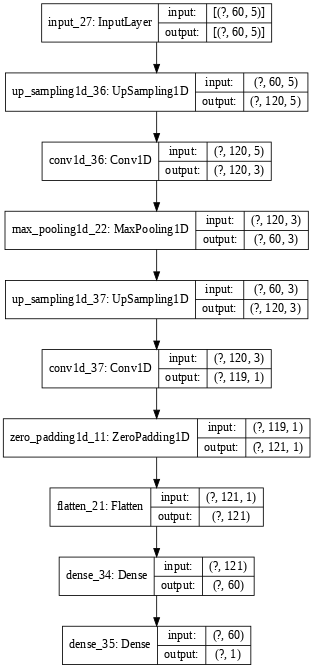

In [80]:
# CNN: LocallyConnected1D
input = Input(shape = (xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке
x = UpSampling1D(size=2)(input)  # Повторяет время каждого временного шага по оси времени
x = Conv1D(3, 2, padding='same', activation='linear')(x) # схлопнул все 5 столбцов в 3
x = MaxPooling1D(pool_size=2)(x)
x = UpSampling1D(size=2)(x)  # Повторяет время каждого временного шага по оси времени
x = Conv1D(1, 2, activation='linear')(x) # схлопнул все 3 столбца в 1
x = ZeroPadding1D(padding=1)(x)
x = Flatten()(x)
x = Dense(xTrain.shape[1], activation='linear')(x)
#x = Dense(xTrain.shape[2], activation='linear')(x)
x = Dense(1, activation='linear')(x)

model = Model(input, x)

plot_model(model, dpi=60, show_shapes=True, show_layer_names=True)

In [81]:
model.compile(optimizer=Nadam(learning_rate=0.0001), loss='mse')

# коллбэки
early_stopping = EarlyStopping(monitor = 'loss', patience = 8, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, min_lr=1e-06, verbose = 1)

# fit model
history = model.fit(xTrain, yTrain, epochs=40, verbose=0,
                    validation_data=([xTest, yTest]),
                    #callbacks = [early_stopping, reduce_lr])
                    callbacks = [early_stopping, reduce_lr, pltMae])


Эпоха: 0 Разица  std: -25.701   Сред.модуль ошибки: 0.728   Накопл.откл.:  0.315    0.521

Эпоха: 1 Разица  std: -14.182   Сред.модуль ошибки: 0.446   Накопл.откл.:  0.154    0.3

Эпоха: 2 Разица  std: -7.823   Сред.модуль ошибки: 0.166   Накопл.откл.:  0.059    0.113

Эпоха: 3 Разица  std: -4.505   Сред.модуль ошибки: 0.222   Накопл.откл.:  0.187    0.205

Эпоха: 4 Разица  std: -2.847   Сред.модуль ошибки: 0.001   Накопл.откл.:  0.038    0.02

Эпоха: 5 Разица  std: -2.201   Сред.модуль ошибки: 0.0   Накопл.откл.:  0.036    0.018

Эпоха: 6 Разица  std: -1.916   Сред.модуль ошибки: 0.023   Накопл.откл.:  0.01    0.017

Эпоха: 7 Разица  std: -1.733   Сред.модуль ошибки: 0.007   Накопл.откл.:  0.04    0.024

Эпоха: 8 Разица  std: -1.62   Сред.модуль ошибки: 0.003   Накопл.откл.:  0.035    0.019

Эпоха: 9 Разица  std: -1.479   Сред.модуль ошибки: 0.003   Накопл.откл.:  0.029    0.016

Эпоха: 10 Разица  std: -1.431   Сред.модуль ошибки: 0.006   Накопл.откл.:  0.038    0.022

Эпоха: 11 Рази

1/1 [==============================] - 0s 1ms/step

Средний модуль ошибки 0.006
Корреляция yTest и yPred накопленных:  [25.301567] 



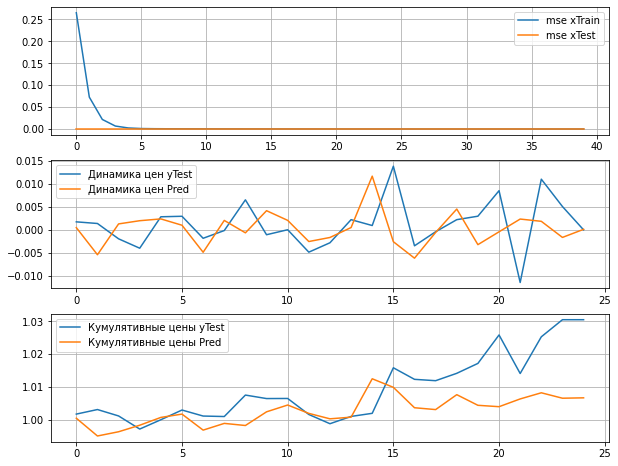

In [82]:
# prediction
yPred = model.predict([xTest], verbose=1)
absDelta = float(abs(sum(yPred)-sum(yTest)/len(yTest))) #Берём модуль отклоненияsum(absDelta)/len(absDelta)
print('\nСредний модуль ошибки', round(absDelta, 3))
print('Корреляция yTest и yPred накопленных: ', np.correlate((yTest+1).cumprod(), (yPred+1).cumprod()), '\n')

#Выводим график ежедневной динамики цен
ax3 = plt.subplot2grid(shape=(3,1), loc=(0,0))
ax3 = plt.plot(history.history['loss'], label='mse xTrain')
ax3 = plt.plot(history.history['val_loss'], label='mse xTest')
plt.legend()
plt.grid()

#Выводим график ежедневной динамики цен
ax2 = plt.subplot2grid(shape=(3,1), loc=(1,0))
ax2 = plt.plot(yTest, label='Динамика цен yTest')
ax2 = plt.plot(yPred, label='Динамика цен Pred')
plt.legend()
plt.grid()

#Выводим график НАКОПЛЕННЫХ изменнений цен
ax1 = plt.subplot2grid(shape=(3,1), loc=(2,0)) # и ax2 - нижняя строка
ax1 = plt.plot((yTest+1).cumprod(), label='Кумулятивные цены yTest')
ax1 = plt.plot((yPred+1).cumprod(), label='Кумулятивные цены Pred')
plt.legend()
plt.grid()

plt.gcf().set_size_inches(10,8)

## Прогнозирование сложными сетями

### Concatenate и ее схема на целый лист )))
------
нет предела совершенства - нужно писать коллбэк, который будет сохранять лучшую модель по нужным параметрам (например, по разнице std).. иначе получается лотерея

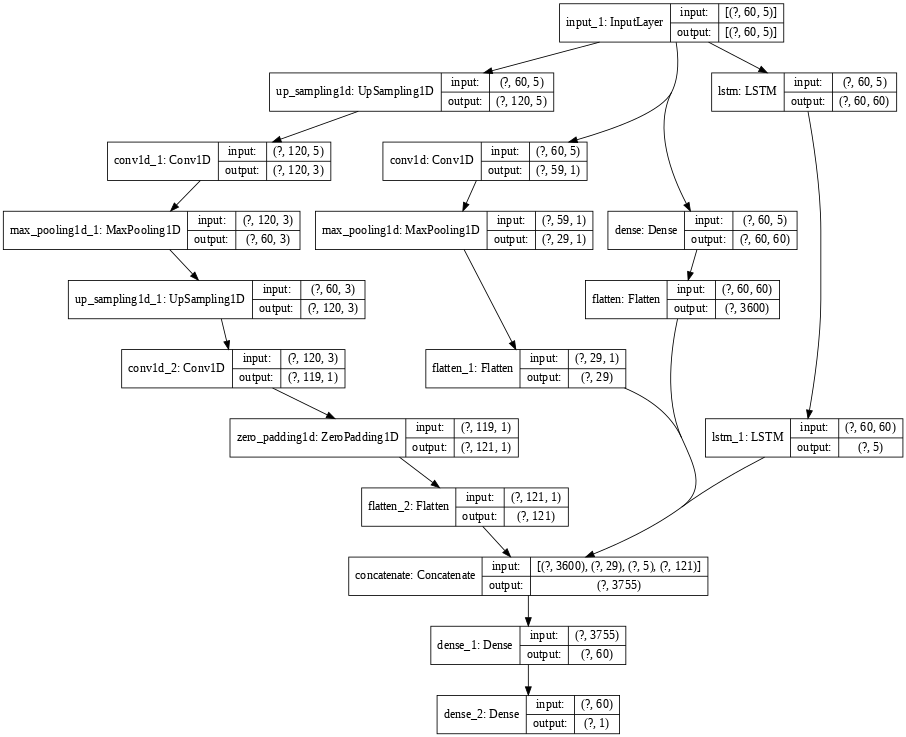

In [13]:
input = Input(shape = (xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке

x1 = Dense(xTrain.shape[1], activation='linear', input_dim=xTrain.shape[1])(input)
#x1 = Dense(xTrain.shape[1]//2, activation='linear')(x1)
x1 = Flatten()(x1)

# CNN: LocallyConnected1D
x2 = Conv1D(1, 2, activation='linear')(input) # слопнул все 5 столбцов в 1
x2 = MaxPooling1D(pool_size=2)(x2)
x2 = Flatten()(x2)

x3 = LSTM(xTrain.shape[1], return_sequences="True")(input)
#x3 = Flatten()(x3)
x3 = LSTM(xTrain.shape[2])(x3)

x4 = UpSampling1D(size=2)(input)  # Повторяет время каждого временного шага по оси времени
x4 = Conv1D(3, 2, padding='same', activation='linear')(x4) # схлопнул все 5 столбцов в 3
x4 = MaxPooling1D(pool_size=2)(x4)
x4 = UpSampling1D(size=2)(x4)  # Повторяет время каждого временного шага по оси времени
x4 = Conv1D(1, 2, activation='linear')(x4) # схлопнул все 3 столбца в 1
x4 = ZeroPadding1D(padding=1)(x4)
x4 = Flatten()(x4)


x = concatenate([x1, x2, x3, x4])
x = Dense(xTrain.shape[1], activation='linear')(x)
#x = Dense(xTrain.shape[2], activation='linear')(x)
x = Dense(1, activation='linear')(x)

model = Model(input, x)

plot_model(model, dpi=60, show_shapes=True, show_layer_names=True)

In [19]:
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='mse')

# коллбэки
early_stopping = EarlyStopping(monitor = 'loss', patience = 8, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, min_lr=1e-06, verbose = 1)

# fit model
history = model.fit(xTrain, yTrain, epochs=300, verbose=0,
                    validation_data=([xTest, yTest]),
                    #callbacks = [early_stopping, reduce_lr])
                    callbacks = [early_stopping, reduce_lr, pltMae])

Эпоха: 0 Разница  std: -0.79   Сред.модуль ошибки: 0.041   Накопл.откл.:  0.07    0.055
Эпоха: 1 Разница  std: -0.726   Сред.модуль ошибки: 0.054   Накопл.откл.:  0.082    0.068
Эпоха: 2 Разница  std: -1.339   Сред.модуль ошибки: 0.063   Накопл.откл.:  0.033    0.048
Эпоха: 3 Разница  std: -0.949   Сред.модуль ошибки: 0.041   Накопл.откл.:  0.011    0.026
Эпоха: 4 Разница  std: -0.92   Сред.модуль ошибки: 0.01   Накопл.откл.:  0.021    0.015

Epoch 00006: ReduceLROnPlateau reducing learning rate to 8.999999772640876e-05.
Эпоха: 5 Разница  std: -1.142   Сред.модуль ошибки: 0.035   Накопл.откл.:  0.004    0.02
Эпоха: 6 Разница  std: -0.985   Сред.модуль ошибки: 0.037   Накопл.откл.:  0.007    0.022
Эпоха: 7 Разница  std: -1.41   Сред.модуль ошибки: 0.043   Накопл.откл.:  0.012    0.028
Эпоха: 8 Разница  std: -0.989   Сред.модуль ошибки: 0.031   Накопл.откл.:  0.061    0.046
Эпоха: 9 Разница  std: -0.625   Сред.модуль ошибки: 0.027   Накопл.откл.:  0.002    0.015
Эпоха: 10 Разница  std: -

1/1 [==============================] - 0s 1ms/step

Средний модуль ошибки 0.016
Корреляция yTest и yPred накопленных:  [25.35685301] 



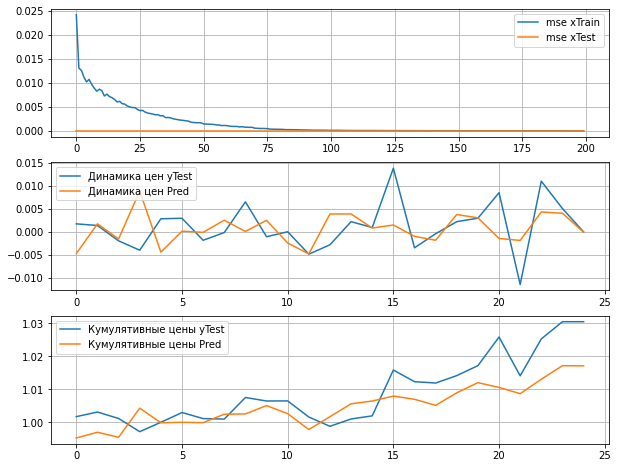

In [15]:
# prediction
yPred = model.predict([xTest], verbose=1)
absDelta = float(abs(sum(yPred)-sum(yTest)/len(yTest))) #Берём модуль отклоненияsum(absDelta)/len(absDelta)
print('\nСредний модуль ошибки', round(absDelta, 3))
print('Корреляция yTest и yPred накопленных: ', np.correlate((yTest+1).cumprod(), (yPred+1).cumprod()), '\n')

#Выводим график ежедневной динамики цен
ax3 = plt.subplot2grid(shape=(3,1), loc=(0,0))
ax3 = plt.plot(history.history['loss'], label='mse xTrain')
ax3 = plt.plot(history.history['val_loss'], label='mse xTest')
plt.legend()
plt.grid()

#Выводим график ежедневной динамики цен
ax2 = plt.subplot2grid(shape=(3,1), loc=(1,0))
ax2 = plt.plot(yTest, label='Динамика цен yTest')
ax2 = plt.plot(yPred, label='Динамика цен Pred')
plt.legend()
plt.grid()

#Выводим график НАКОПЛЕННЫХ изменнений цен
ax1 = plt.subplot2grid(shape=(3,1), loc=(2,0)) # и ax2 - нижняя строка
ax1 = plt.plot((yTest+1).cumprod(), label='Кумулятивные цены yTest')
ax1 = plt.plot((yPred+1).cumprod(), label='Кумулятивные цены Pred')
plt.legend()
plt.grid()

plt.gcf().set_size_inches(10,8)

## Примеры дополнительных данных, которые можно применить в анализе

### Дополнительная статистика из Yahoo Finance

In [ ]:
LMT = yf.Ticker("LMT") # Lockheed Martin
LMT.history(period="max")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1977-01-03,0.34,0.35,0.34,0.35,165200.0,0.0,0.0
1977-01-04,0.35,0.35,0.33,0.35,179800.0,0.0,0.0
1977-01-05,0.35,0.36,0.35,0.36,189600.0,0.0,0.0
1977-01-06,0.36,0.38,0.36,0.38,384200.0,0.0,0.0
1977-01-07,0.38,0.38,0.37,0.38,345200.0,0.0,0.0
...,...,...,...,...,...,...,...
2020-09-03,399.50,401.88,383.38,386.29,1500800.0,0.0,0.0
2020-09-04,388.51,391.55,379.58,385.02,933600.0,0.0,0.0
2020-09-08,383.99,385.29,378.36,380.23,1071600.0,0.0,0.0


In [ ]:
LMT.sustainability

,Value
2020-8,
palmOil,False
controversialWeapons,True
gambling,False
socialScore,16.09
nuclear,False
furLeather,False
alcoholic,False
gmo,False
catholic,False


In [ ]:
LMT.institutional_holders

,Holder,Shares,Date Reported,% Out,Value
0,State Street Corporation,42435377,2020-06-29,0.1518,15485517774
1,"Vanguard Group, Inc. (The)",22246588,2020-06-29,0.0796,8118224892
2,Blackrock Inc.,16985580,2020-06-29,0.0608,6198377853
3,Capital World Investors,16595630,2020-06-29,0.0594,6056077299
4,"Wellington Management Company, LLP",10758413,2020-06-29,0.0385,3925960071
5,Bank of America Corporation,9017771,2020-06-29,0.0323,3290764993
6,"Geode Capital Management, LLC",4094244,2020-06-29,0.0146,1494071520
7,"Ameriprise Financial, Inc.",3371326,2020-06-29,0.0121,1230264283
8,"FMR, LLC",3368655,2020-06-29,0.0121,1229289582
9,Northern Trust Corporation,3167070,2020-06-29,0.0113,1155727184


In [ ]:
LMT.major_holders

,0,1
0,0.07%,% of Shares Held by All Insider
1,80.38%,% of Shares Held by Institutions
2,80.44%,% of Float Held by Institutions
3,2142,Number of Institutions Holding Shares


In [ ]:
LMT.recommendations

,Firm,To Grade,From Grade,Action
Date,,,,
2011-12-30 02:00:00,Guggenheim,Sell,,down
2012-04-11 06:24:00,Deutsche Bank,Hold,,main
2012-04-27 07:13:00,Credit Suisse,Neutral,,main
2012-04-27 08:33:00,JP Morgan,Neutral,,main
2012-07-17 07:16:00,Citigroup,Buy,,main
...,...,...,...,...
2020-03-25 15:03:44,Morgan Stanley,Equal-Weight,,main
2020-04-14 14:41:13,Morgan Stanley,Equal-Weight,,main
2020-04-22 12:20:34,Credit Suisse,Neutral,,main


# Выводы:
----
нашел способ быстро и красиво рисовать графики акций. Думаю, может и УИИ пригодиться в 7м уроке, чтобы не рисовать 5 линий ))
ну а в целом: 
1. достаточно точно на 10м баре можно предсказать только направление движения цены
2. нужно искать другие варианты, например, добавить колонку с 0 и 1, показывающую направление движения цены
3. пытался упростить подбор гиперпараметров, ставя длину строки или количество колонок.. в принципе, удобно, но лучше делать функцию подбора гиперпараметров (если цель того стоит))
4. для предсказания на  каждый из N шагов вперед имеет смысл делать отдельную НС, а не пытаться все впихнуть в одну
----
5. ну и горе: не справился со Scaler (((
был бы рад за помощь (выделил внутри кода коричневым) что именно скалировать на входе (весь df или отдельно X и y??) и важнее - что делать с предиктом, чтобы отрисовались графики?